In [1]:
#fundumental libriaries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [2]:
# required libriaies for scrapping
from bs4 import BeautifulSoup
from urllib.parse import urljoin
from urllib.request import urlopen
import urllib.request

In [3]:
# scrapping index compenants
user_agent = 'Mozilla/5.0 (Windows; U; Windows NT 5.1; en-US; rv:1.9.0.7) Gecko/2009021910 Firefox/3.0.7'
url =  'https://en.wikipedia.org/wiki/Dow_Jones_Industrial_Average#Components'
headers={'User-Agent':user_agent,} 
request=urllib.request.Request(url,None,headers) #The assembled request
response = urllib.request.urlopen(request)
data = response.read() # The data u need
soup = BeautifulSoup(data, 'lxml')
text = soup.get_text()
row = soup.find('tr')
companies = []
tickers = []
dw_weight =[]
exchange=[]
industry=[]

rows = soup.find_all('tr')
for row in rows[11:41]:          # Print all occurrences
    a = row.get_text()
    a = a.split('\n')
    companies.append(a[1])
    exchange.append(a[3])
    if a[3]=='NYSE':
        tickers.append(str(a[5])[6:])
        
    else:
        tickers.append(a[5])
        
    industry.append(a[7])
    dw_weight.append(a[13])
    
  

In [4]:
#Dow stock history starts from 2019, in order to big-enough data size,  dow stock was replaced by amzn
tickers.index('DOW')
tickers[9]='AMZN'

In [5]:
#downloading the price data
start = '2010-12-15'
end = '2015-12-15'
interval = "1d"
df = yf.download(tickers, start,end,interval)

[*********************100%***********************]  30 of 30 completed


In [6]:
#correcting weight data format
dj_weight = []
for i in dw_weight:
   dj_weight.append(float(i.replace('%','')))

In [7]:
#imputing missing values
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=2, weights="uniform")
imputer.fit_transform(df)

array([[9.86995697e+00, 4.43803596e+01, 1.75570007e+02, ...,
        1.65981000e+07, 7.38880000e+06, 1.05502000e+07],
       [9.89737797e+00, 4.51456757e+01, 1.78039993e+02, ...,
        1.66089000e+07, 7.53990000e+06, 1.23353000e+07],
       [9.87766075e+00, 4.57754555e+01, 1.77580002e+02, ...,
        2.46766000e+07, 1.56603000e+07, 2.15622000e+07],
       ...,
       [2.69070492e+01, 1.38836182e+02, 6.62320007e+02, ...,
        1.04025000e+07, 2.69270000e+06, 1.13594000e+07],
       [2.62145119e+01, 1.34905930e+02, 6.40150024e+02, ...,
        1.64819000e+07, 4.20910000e+06, 9.74500000e+06],
       [2.60523796e+01, 1.37479706e+02, 6.57909973e+02, ...,
        1.67231000e+07, 3.98030000e+06, 1.45249000e+07]])

In [8]:
#dropping nan values
df.dropna(inplace=True)

In [9]:
#generating index dat by using given dji portfolio weights and stock prices
df_ind = pd.DataFrame(index=df.index)
for i in ['Open','High','Low','Close','Volume']:
    df_ind[i] = (df[i]*dj_weight).sum(axis=1)
    

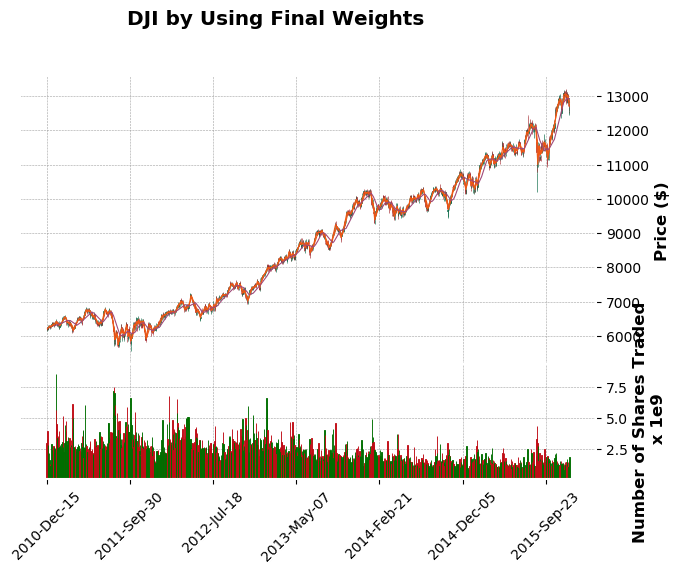

In [10]:
# Visualizing the index and volume
import mplfinance as mpf


mpf.plot(df_ind, type='candle', style='charles',
            title= 'DJI by Using Final Weights' ,
            ylabel='Price ($)',
            ylabel_lower='Number of Shares Traded',
            volume=True, 
            mav=(3,6,20), 
           )
plt.show()

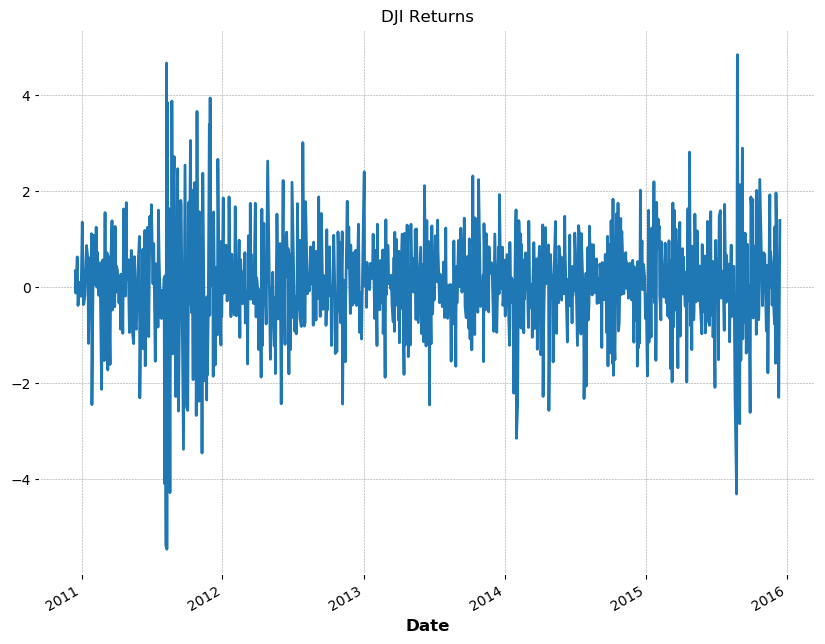

In [11]:
#Generating return and showing on the chart 
df_ind['Return'] = df_ind['Close'].pct_change()*100
df_ind.dropna(inplace=True)
fig = plt.figure(figsize=(10,8))
df_ind['Return'].plot()
plt.title('DJI Returns')
plt.show()

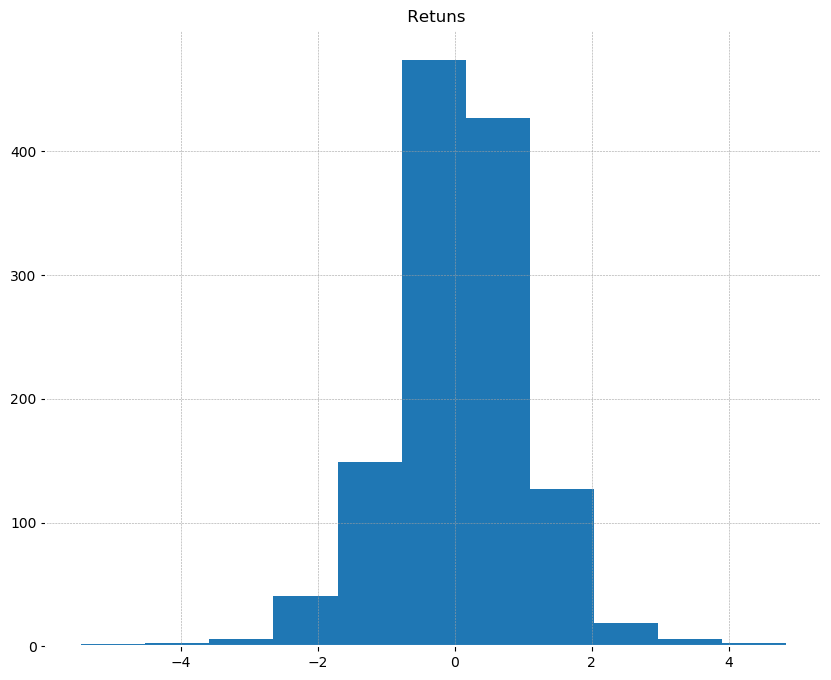

In [12]:
# the dji retun distribution
bins = int(round(1 + (3.322*np.log10(len(df_ind)))))

fig= plt.figure(figsize=(10,8))
plt.hist(df_ind['Return'].values,bins=bins)
plt.xlabel = 'Returns'
plt.ylabel = 'Frequency'
plt.title(' Retuns')
plt.show()

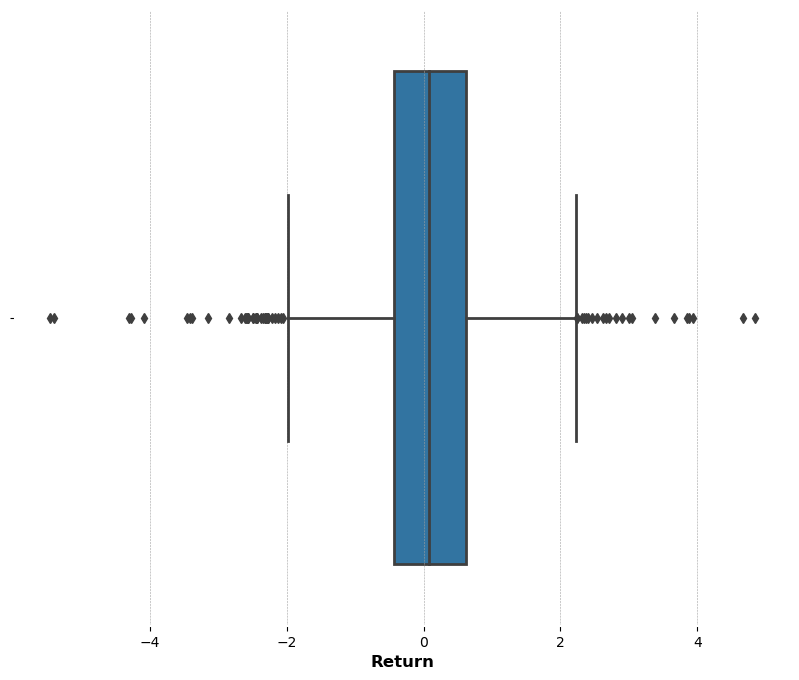

In [13]:
# Visualizing descriptive dji return statistics
import seaborn as sns
fig= plt.figure(figsize=(10,8))
sns.boxplot(x=df_ind['Return'])
plt.show()

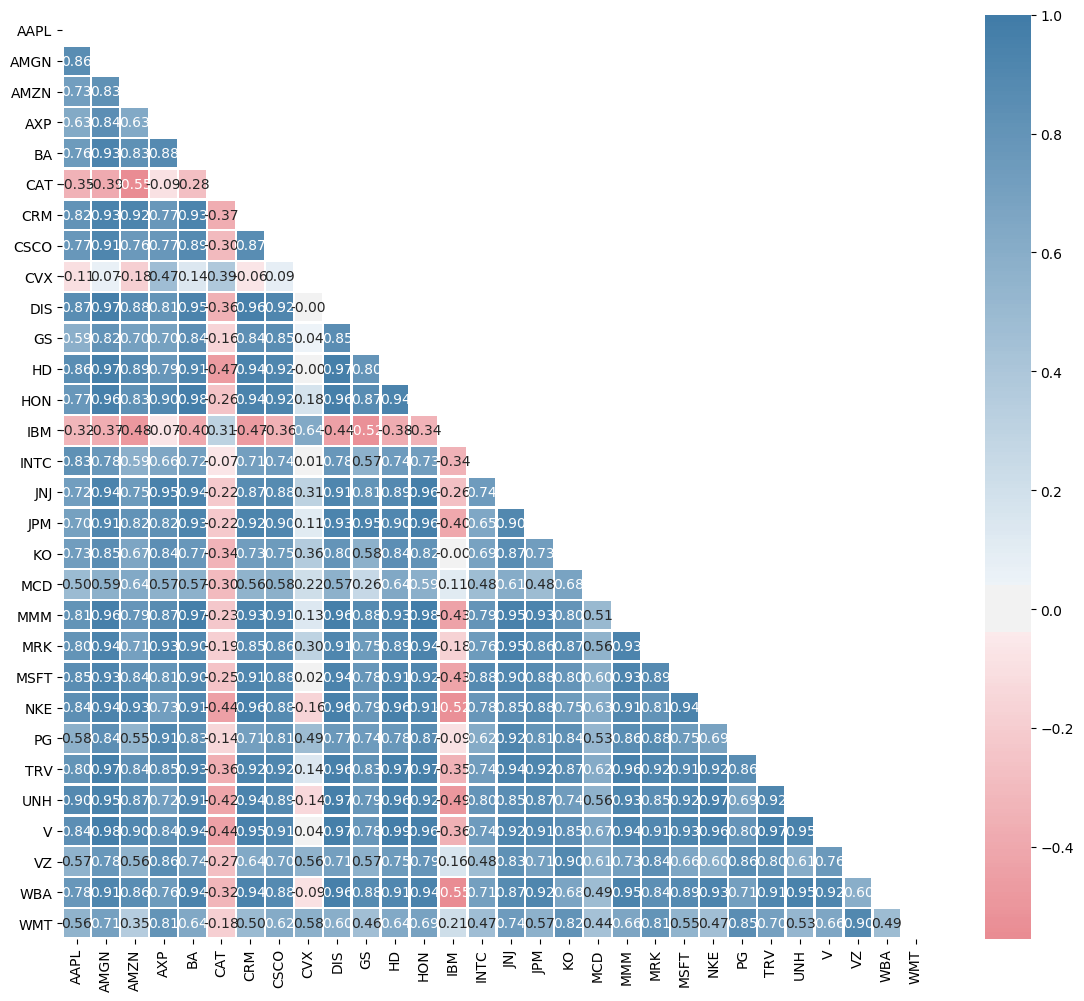

In [14]:
import seaborn as sns
# Correlation Matrix and visualazing it on heat map
corr = df['Close'].pct_change().dropna().corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(h_neg=10,h_pos=240,as_cmap=True)
figure = plt.figure(figsize=(14,12))
sns.heatmap(df['Close'].dropna().corr(), mask=mask,center=0, cmap=cmap, linewidths=1,annot=True, fmt=".2f")
plt.show()

In [15]:
# Calculate expected annualized returns and risk
from pypfopt import risk_models, expected_returns
from pypfopt import plotting

mu = expected_returns.capm_return(df['Adj Close'])*100
S = risk_models.semicovariance(df['Adj Close'])*100


Using the Community license in this session. If you have a full Xpress license, first set the XPAUTH_PATH environment variable to the full path to your license file, xpauth.xpr, and then restart Python. If you want to use the FICO Community license and no longer want to see this message, set the XPAUTH_PATH environment variable to: C:\Users\Mehmet\anaconda3\lib\site-packages\xpress\license\community-xpauth.xpr
NB: setting XPAUTH_PATH will also affect any other Xpress products installed on your system.


In [16]:
max_ret = mu[mu==mu.max()]
min_ret = mu [mu==mu.min()]
avg_mean = mu.mean()
print('The higest expected return is on the stock %s with%6.2f%%.' % (max_ret.index[0],max_ret[0]))
print('The lowest expected return is on the stock %s with%6.2f%%.' % (min_ret.index[0],min_ret[0]))
print('The higeaveragest expected return is %6.2f%%.' % avg_mean)

The higest expected return is on the stock CRM with 24.47%.
The lowest expected return is on the stock WMT with 10.88%.
The higeaveragest expected return is  17.15%.


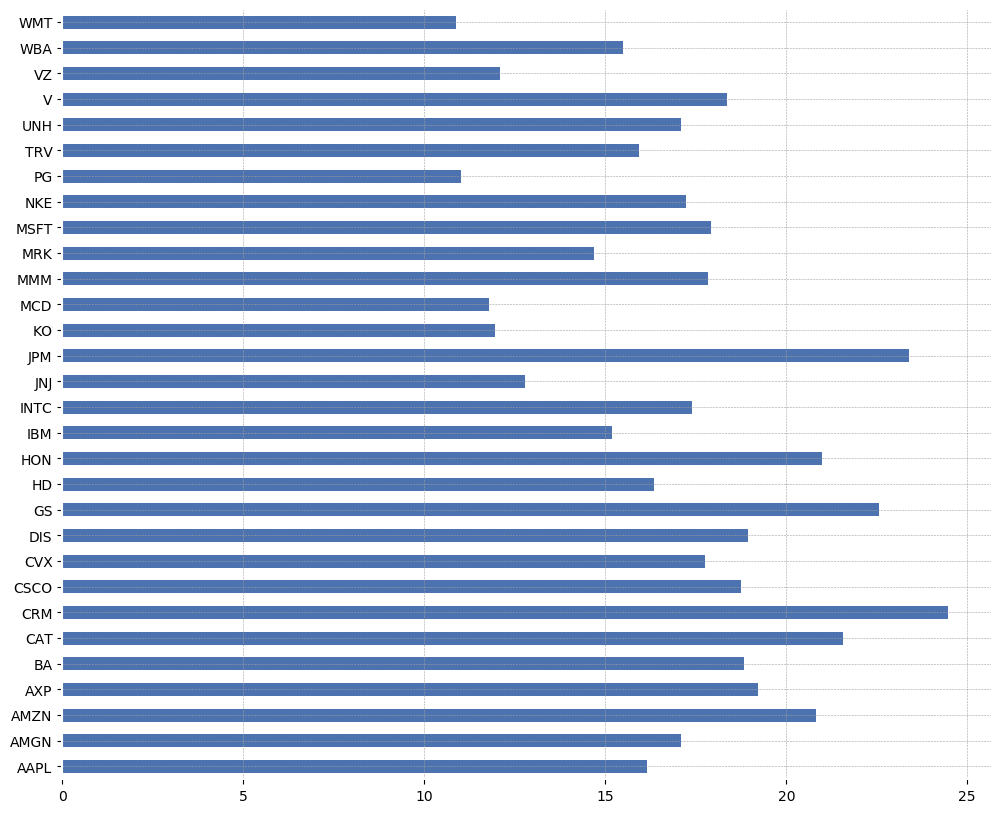

In [17]:
# Expected returns of dji compenenats
mu.plot.barh(figsize=(12,10));

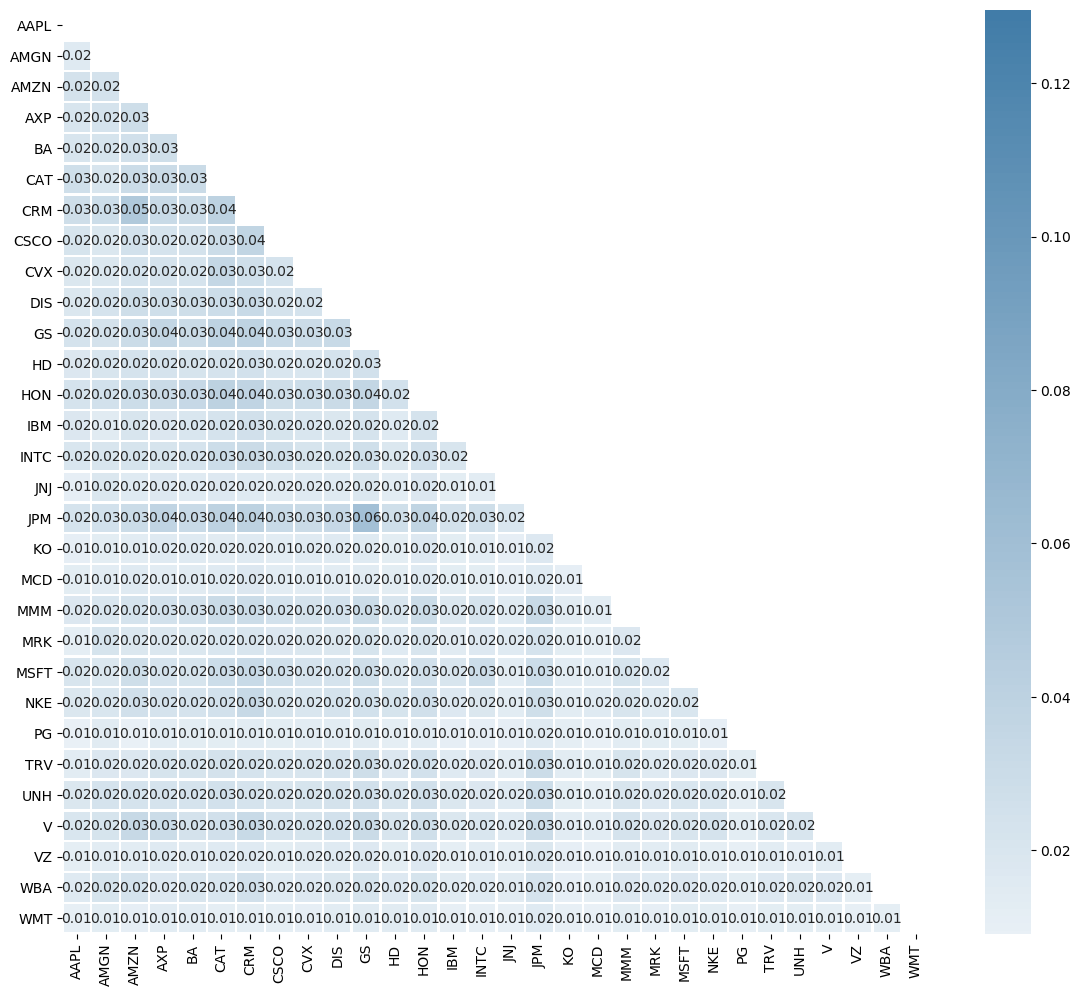

In [18]:
# Ledoit-Wolf shrinkage, which reduces the extreme values in the covariance matrix
corr_n = risk_models.CovarianceShrinkage(df['Close']).ledoit_wolf()
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(h_neg=10,h_pos=240,as_cmap=True)
figure = plt.figure(figsize=(14,12))
sns.heatmap(risk_models.CovarianceShrinkage(df['Close']).ledoit_wolf(), mask=mask,center=0, cmap=cmap, linewidths=1,annot=True, fmt=".2f")
plt.show()

OrderedDict([('AAPL', 0.04186), ('AMGN', -0.03874), ('AMZN', 0.00667), ('AXP', -0.0017), ('BA', -0.00699), ('CAT', 0.00591), ('CRM', -0.00696), ('CSCO', 0.00517), ('CVX', -0.00924), ('DIS', -0.02547), ('GS', 0.00804), ('HD', 0.00575), ('HON', -0.11108), ('IBM', 0.05608), ('INTC', 0.03681), ('JNJ', 0.21615), ('JPM', -0.08348), ('KO', 0.13948), ('MCD', 0.18707), ('MMM', -0.01786), ('MRK', 0.01158), ('MSFT', -0.01747), ('NKE', 0.00952), ('PG', 0.19099), ('TRV', 0.04632), ('UNH', 0.02012), ('V', 0.00066), ('VZ', 0.14892), ('WBA', 0.01679), ('WMT', 0.16508)])


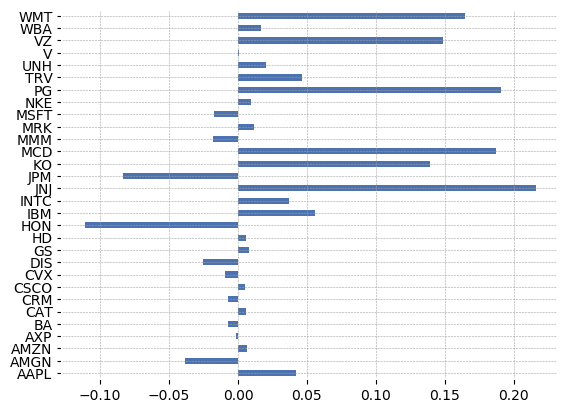

In [19]:
#minimum variance portfolio
from pypfopt import EfficientFrontier
S = risk_models.CovarianceShrinkage(df['Close']).ledoit_wolf()

# You don't have to provide expected returns in this case
ef_min_var = EfficientFrontier(None, S, weight_bounds=(-1, 1))
ef_min_var.min_volatility()
weights_min_var = ef_min_var.clean_weights()
print(weights_min_var)
#longs-shorts
pd.Series(weights_min_var).plot.barh();

In [20]:
#Minimum variance portfolio volatility(annual)
ef_min_var.portfolio_performance(verbose=True)

Annual volatility: 10.8%


(None, 0.10765769899296623, None)

In [21]:
#making dictionanary with ticker and sectors
sector_mapper={}
for i,j in zip(tickers,industry):
    sector_mapper[i] =j

In [22]:
#making sector constraint for the optimization
sector_lower = {
    "Broadcasting and entertainment": 0.1, # at least 10% to staples
    "Information technology": 0.05 # at least 5% to tech
    # For all other sectors, it will be assumed there is no lower bound
}

sector_upper = {
    "Information technology": 0.2,
    "Aerospace and defense":0.1,
    "Food industry": 0.1,
    "Retailing":0.15
}

In [23]:
from pypfopt import EfficientFrontier, objective_functions
## 1% broker commission
#For example, let's say that in addition to the above sector constraints, I specifically want:10% of the portfolio in AAPL
#Less than 5% of my portfolio in CAT

mu_opt = expected_returns.capm_return(df['Close'])*100
S_opt = risk_models.CovarianceShrinkage(df['Close']).ledoit_wolf()*100

ef_opt = EfficientFrontier(mu_opt, S_opt,weight_bounds=(-1, 1))  #  # -1 indicates short selling

ef_opt.add_objective(objective_functions.transaction_cost, w_prev=dj_weight, k=0.001)
ef_opt.add_objective(objective_functions.L2_reg, gamma=0.05)  # default is 1

ef_opt.add_sector_constraints(sector_mapper, sector_lower, sector_upper)

aapl_index = ef_opt.tickers.index("AAPL")
ef_opt.add_constraint(lambda w: w[aapl_index] == 0.10)

cat_index = ef_opt.tickers.index("CAT")
ef_opt.add_constraint(lambda w: w[cat_index] <= 0.05)

ef_opt.add_constraint(lambda w: w[10] >= 0.05)

ef_opt.max_sharpe()
weights_opt = ef_opt.clean_weights()

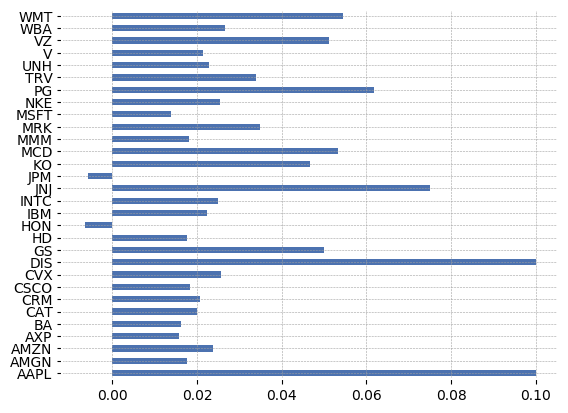

In [24]:
#plotting weights
pd.Series(weights_opt).plot.barh();

In [25]:
#Number of stocksexcluded or shorted from the portfolio
num_small = len([k for k in weights_opt if weights_opt[k] <= 1e-4])
print(f"{num_small}/{len(ef_opt.tickers)} tickers have zero or minus weight")

2/30 tickers have zero or minus weight


In [26]:
#the expected portfolio performance
ef_opt.portfolio_performance(verbose=True);

Expected annual return: 1331.6%
Annual volatility: 135.5%
Sharpe Ratio: 9.81


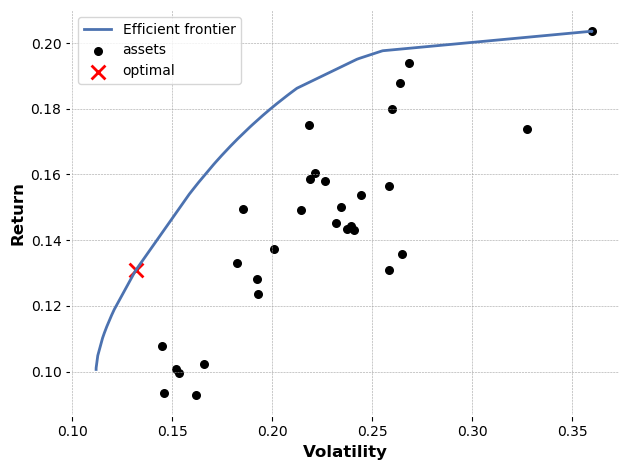

In [27]:
#plotting  efficient frontier
from pypfopt import CLA, plotting
cla = CLA((mu_opt/100), (S_opt/100),weight_bounds=(0, 1))
cla.max_sharpe()
cla.portfolio_performance(verbose=False, risk_free_rate=0.02);
plotting.plot_efficient_frontier(cla, points=100, show_assets=True);

In [28]:
#Making the same portfolio optimization by using exponential weighted return and volatility
# Exponentially weighted moving average
mu_ema = expected_returns.ema_historical_return(df['Adj Close'],span=252, frequency=252)*100
# Exponentially weighted covariance
Sigma_ew = risk_models.exp_cov(df['Adj Close'], span=180, frequency=252)*100

In [29]:
ef_exp = EfficientFrontier(mu_ema, Sigma_ew,weight_bounds=(-1, 1))  # -1 indicates short selling

ef_exp.add_objective(objective_functions.transaction_cost, w_prev=dj_weight, k=0.001)
ef_exp.add_objective(objective_functions.L2_reg, gamma=0.05)  # default is 1

ef_exp.add_sector_constraints(sector_mapper, sector_lower, sector_upper)

aapl_index = ef_exp.tickers.index("AAPL")
ef_exp.add_constraint(lambda w: w[aapl_index] == 0.10)

cat_index = ef_exp.tickers.index("CAT")
ef_exp.add_constraint(lambda w: w[cat_index] <= 0.05)

ef_exp.add_constraint(lambda w: w[10] >= 0.05)

ef_exp.max_sharpe()
weights_exp = ef_exp.clean_weights()

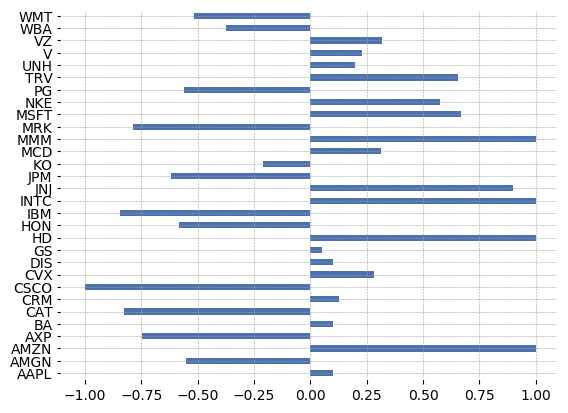

In [30]:
#portfolio weights
pd.Series(weights_exp).plot.barh();

In [31]:
#stocks exluded or shorted
num_small = len([k for k in weights_exp if weights_exp[k] <= 1e-4])
print(f"{num_small}/{len(ef_exp.tickers)} tickers have zero or minus weight")

12/30 tickers have zero or minus weight


In [32]:
#Expected portfolio performance
ef_exp.portfolio_performance(verbose=True);

Expected annual return: 32989.5%
Annual volatility: 546.8%
Sharpe Ratio: 60.33


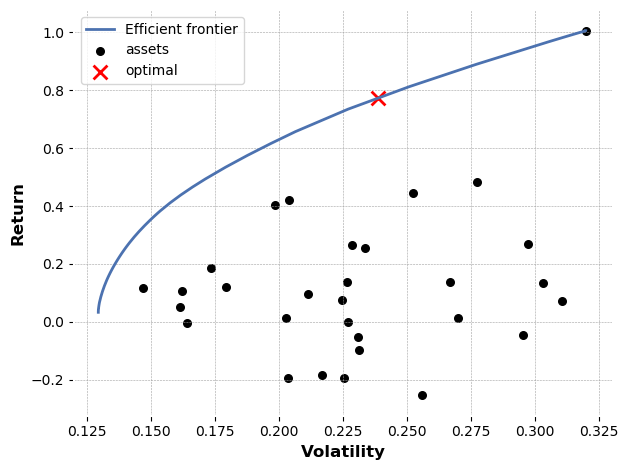

In [33]:
#efficient frontier
cla = CLA((mu_ema/100), (Sigma_ew/100),weight_bounds=(0, 1))
cla.max_sharpe()
cla.portfolio_performance(verbose=False, risk_free_rate=0.02);
plotting.plot_efficient_frontier(cla, points=100, show_assets=True);

In [34]:
#Downloading testing data
end = '2021-01-15'
start = '2015-12-15'
interval = "1d"
test = yf.download(tickers, start,end,interval)

[*********************100%***********************]  30 of 30 completed


In [35]:
#test data
test = test['Adj Close'].pct_change().dropna()
test

,AAPL,AMGN,AMZN,AXP,BA,CAT,CRM,CSCO,CVX,DIS,...,MRK,MSFT,NKE,PG,TRV,UNH,V,VZ,WBA,WMT
Date,,,,,,,,,,,,,,,,,,,,,
2015-12-16,0.007693,0.012053,0.026008,0.007982,0.010782,0.014532,0.019646,0.014525,0.007331,0.014533,...,0.021172,0.016848,0.018039,0.016441,0.012016,0.010373,0.015772,0.021075,0.031665,0.011066
2015-12-17,-0.021196,-0.019140,-0.007577,-0.016122,-0.017217,-0.041642,-0.005831,-0.019090,-0.031036,-0.015643,...,-0.025176,-0.007661,-0.005423,-0.008643,-0.011088,0.003282,-0.014650,-0.008815,-0.016173,-0.021890
2015-12-18,-0.027069,-0.016292,-0.009707,-0.024436,-0.041082,0.003236,-0.017850,-0.016841,-0.008063,-0.038300,...,-0.019370,-0.028187,-0.013055,-0.026903,-0.027721,-0.028519,-0.030118,-0.011714,-0.009959,-0.002204
2015-12-21,0.012261,0.003023,0.000557,0.007809,0.009457,0.001996,0.003375,0.014084,-0.006347,-0.010490,...,0.004454,0.012932,0.009960,0.010495,0.007355,0.013728,0.011137,0.007463,0.028845,0.011895
2015-12-22,-0.000932,0.018960,-0.002047,0.006579,0.010504,0.048590,0.007375,0.009384,0.011542,0.001407,...,0.004434,0.009484,0.015793,0.008233,0.013881,0.000255,0.002721,0.009586,0.013194,0.016625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-08,0.008631,0.019101,0.006496,0.000986,-0.013211,0.000154,0.018626,0.002224,0.009532,0.000616,...,-0.011783,0.006093,0.009659,-0.000432,0.004170,-0.004493,0.007670,-0.012472,-0.001105,-0.000136
2021-01-11,-0.023249,-0.003858,-0.021519,-0.005912,-0.014817,-0.002059,-0.017069,0.006658,0.005709,0.002238,...,0.023726,-0.009699,0.004783,-0.006773,-0.015897,-0.007265,-0.011882,-0.005882,0.055076,0.004501
2021-01-12,-0.001396,-0.004125,0.002126,0.004626,0.007834,0.018983,-0.012509,0.009480,0.018996,-0.017310,...,-0.022471,-0.011771,-0.013601,-0.005803,0.021757,-0.009369,-0.018930,-0.003481,0.005451,0.011406


In [36]:
#correcting format of dji given weights
dj_port_weights=[]
for i in dj_weight:
    dj_port_weights.append(i/100)
    
    

In [37]:
#weigthted returns
weighted_returns_dji = (dj_port_weights *test).sum(axis=1)
weighted_returns_opt = (weights_opt *test).sum(axis=1)
weighted_returns_ewt = (weights_exp *test).sum(axis=1)

In [38]:
#cumulative returns
cumulative_ret_dji = (weighted_returns_dji + 1).cumprod()
cumulative_ret_opt = (weighted_returns_opt + 1).cumprod()
cumulative_ret_ewt= (weighted_returns_ewt + 1).cumprod()

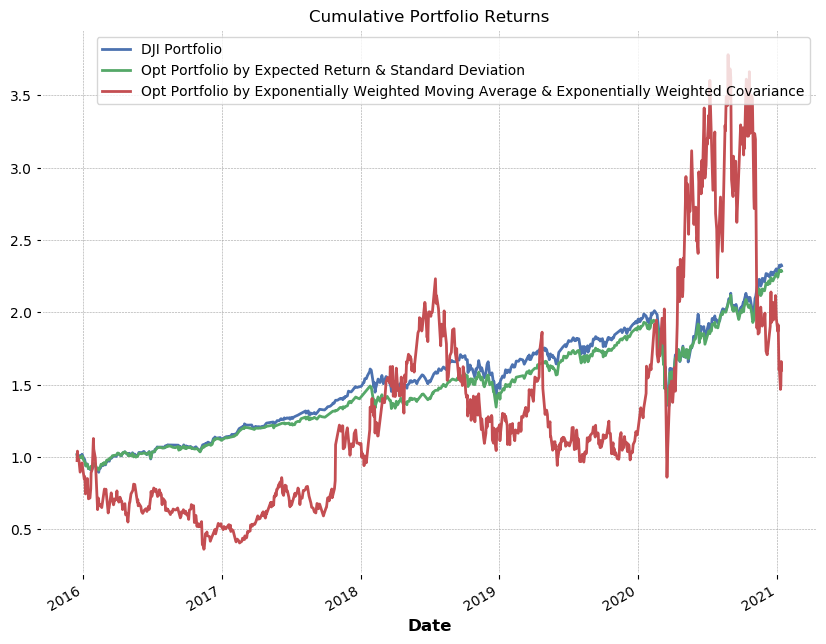

In [39]:
#plotting cumulative returns
fig= plt.figure(figsize=(10,8))
cumulative_ret_dji.plot(label='DJI Portfolio')
cumulative_ret_opt.plot(label='Opt Portfolio by Expected Return & Standard Deviation')
cumulative_ret_ewt.plot(label='Opt Portfolio by Exponentially Weighted Moving Average & Exponentially Weighted Covariance')
plt.legend()
plt.title('Cumulative Portfolio Returns')
plt.show()